In [145]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from autoencoder import AutoEncoder, VariationalAutoEncoder, LSTMAutoEncoder
import resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import PurePosixPath as Path

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = resources.config_paths()
print(TB_DIR)

/mnt/c/Users/tomje/OneDrive - Cardiff University/Documents/PHD/AE/Tensorboard


# Load in RMS data for tests

In [147]:
# exps = ['Test 5', 'Test 7', 'Test 8', 'Test 9']
exps = ['Test 5']
rms = {}

for test in exps:
    rms[test] = resources.ae.RMS(test)
    rms[test].data.drop(['0', '1', '2',], axis=1, inplace=True)
    
try:
    rms['Test 5'].data.drop(['23', '24'], axis=1, inplace=True)
except KeyError:
    pass

--------------------------------------------------
Loaded RMS data for "22_08_03_grit1000"
Experiemnt No: Test 5
Number of files: 213
--------------------------------------------------


In [148]:
def remove_dc(sig):
    return sig - np.nanmean(sig)

for test in exps:
    rms[test]._data = rms[test].data.iloc[50:350, :].reset_index(drop=True)
    rms[test]._data = rms[test].data.apply(remove_dc, axis=0)

In [149]:
# Join 3 datasets for transfer learning
# training section is going to be first 70 cuts of each test

# dfs = [rms[test].data.iloc[:, :70].values for test in exps[:-1]]
# join_df = np.concatenate(dfs, axis=1)
# join_df = pd.DataFrame(join_df)
# print(np.shape(join_df))

# # Create RMS obj for the join_df data
# class join_rms_obj:
#     def __init__(self, data, exp_name):
#         self.data = data
#         self.exp_name = exp_name

# join_rms = join_rms_obj(join_df, 'join_df')
# exps = ['join_rms'] # FOR LSTMAE

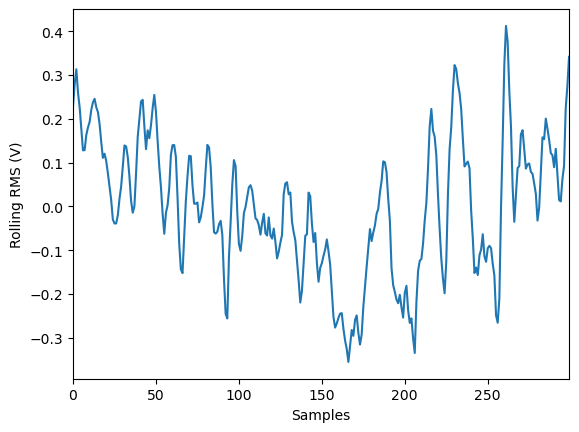

In [150]:
r = rms[test].data.values
r.shape
plt.plot(r[:, 43])
plt.xlabel('Samples')
plt.ylabel('Rolling RMS (V)')
plt.autoscale(enable=True, axis='x', tight=True)
# plt.plot(r[:, 120])
# plt.plot(r[:, 145])

# Setup Autoencoder for each Test
- The model is trained over a small section of the test depending on `train_slice`.
- The model parameters are specified within the `params` dict.

In [151]:
autoe = {}
for test in exps:
        """
        autoe[test] = VariationalAutoEncoder(rms[test],
                                             rms[test].data,
                                             tb=False,
                                             tb_logdir=rms[test].exp_name,
                                             train_slice=(0, 75),
                                             val_frac=0.33,
                                             params={'latent_dim': 4,
                                                   'n_size': [64, 32],
                                                   'epochs': 1000,
                                                   'batch_size': 15,
                                                   'callbacks': [
                                                           tf.keras.callbacks.EarlyStopping(
                                                                monitor='val_loss',
                                                                patience=60,
                                                                mode='min',
                                                                start_from_epoch=100,
                                                           ),
                                                        ]
                                                   }
                                           )
        """
        # '''
        autoe[test] = AutoEncoder(rms[test],
                                  rms[test].data,
                                  tb=False,
                                  tb_logdir=rms[test].exp_name.upper().replace(' ', '_'),
                                  train_slice=(0, 50),
                                  val_frac=0.33,
                                  random_state=1,
                                  params={'n_bottleneck': 16,
                                          'n_size': [64, 64],
                                          'epochs': 1000,
                                          'batch_size': 10,
                                          'loss': 'mse',
                                          'callbacks': [
                                                  tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=80,
                                                              mode='min',
                                                              start_from_epoch= 100,
                                                  ),
                                                #   tf.keras.callbacks.ReduceLROnPlateau(
                                                #                 monitor='val_loss',
                                                #                 mode='min',
                                                #                 patience=25,
                                                #                 factor=0.01,
                                                #   ),
                                                ]

                                          }
                                  )                                
        # '''
        '''
        autoe[test] = LSTMAutoEncoder(join_rms,
                                      join_rms.data,
                                      tb=True,
                                      tb_logdir='LSTMAE_test',
                                      train_slice=(0, 209),
                                      val_frac=0.33,
                                      params={'epochs': 300,
                                              'batch_size': 64,
                                              'n_size': [256, 128, 64],
                                              'seq_len': 100,
                                              'n_bottleneck': 32,
                                              'loss': 'mean_squared_error',
                                              'callbacks': [
                                                      tf.keras.callbacks.EarlyStopping(
                                                        monitor='val_loss',
                                                        patience=10,
                                                        mode='min',
                                                        start_from_epoch= 150,
                                                        ),
                                                 ]
                                      }
                                )
        '''

Pre-Processing Data:
	Training Data: slice(0, 50, None)
	Input train shape: (33, 300)
	Input val shape: (17, 300)

AUTOE-Test_5-E-1000-L-[64, 64, 16, 64, 64]-20230913-160154



In [152]:
# add model checkpoint callback after creating model
for test in exps:
    name = autoe[test].run_name
    model_folder = TB_DIR.joinpath(autoe[test]._tb_logdir.joinpath(name))
    if not os.path.exists(model_folder):
       os.makedirs(model_folder)
    assert os.path.exists(model_folder)

    autoe[test].model.callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(
        filepath=model_folder.joinpath(f'{name}.h5'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
        )
    )

# Train each autoe on the training data
- `x` is the inputted data for training, which is `autoe.train_data`
- `val_data` is the validation data from `autoe.val_data`

In [153]:
for test in exps:
        autoe[test].fit(x=autoe[test].train_data,
                        val_data=autoe[test].val_data,
                        verbose=1,
                        use_multiprocessing=True,
                        )

Training model: AUTOE-Test_5-E-1000-L-[64, 64, 16, 64, 64]-20230913-160154:
Epoch 1/1000
4/4 [==============================] - 2s 89ms/step - loss: 0.1509 - mean_squared_error: 0.1509 - mean_absolute_error: 0.3234 - r_squared: -43.2621 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - val_mean_absolute_error: 0.3289 - val_r_squared: -16.4225
Epoch 2/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.1462 - mean_squared_error: 0.1462 - mean_absolute_error: 0.3197 - r_squared: -153.9039 - val_loss: 0.1246 - val_mean_squared_error: 0.1246 - val_mean_absolute_error: 0.3305 - val_r_squared: -16.5608
Epoch 3/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.1389 - mean_squared_error: 0.1389 - mean_absolute_error: 0.3145 - r_squared: -73.5025 - val_loss: 0.1254 - val_mean_squared_error: 0.1254 - val_mean_absolute_error: 0.3318 - val_r_squared: -16.6664
Epoch 4/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.1363 - mean_squared_error: 0.

## Reload saved weights from best model

In [154]:
for test in exps:
    name = autoe[test].run_name
    model_folder = TB_DIR.joinpath(autoe[test]._tb_logdir.joinpath(name))
    autoe[test].model.model_.load_weights(
        TB_DIR.joinpath(model_folder.joinpath(f'{name}.h5'),),
    )
    autoe[test].pred = None
    autoe[test].scores = None

# Results Visualisation

## Loss plot of each trained model

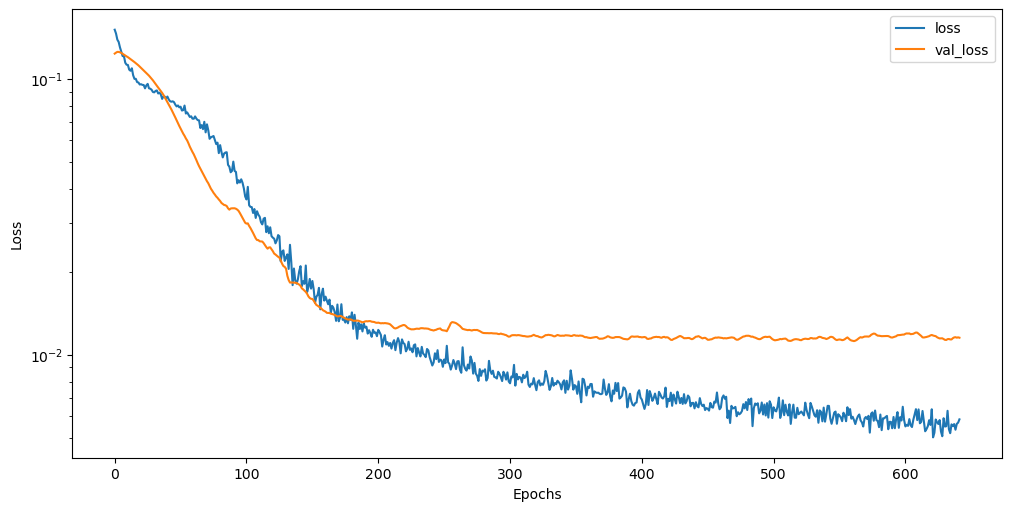

In [155]:
fig, ax = plt.subplots(1, len(exps),
                       figsize=(10,5),
                       constrained_layout=True,
                       )
# ax = ax.ravel()
for i, test in enumerate(exps):
    axis = fig.axes[i]
    autoe[test].loss_plot(plt_ax=axis)
    axis.set_yscale('log')
    if i > 0:
        axis.set_ylabel('')

## Score each model
- Models scored on train, validation and whole dataset

In [156]:
for test in exps:
    autoe[test].scores = None
    autoe[test].pred = None

In [157]:
for test in exps:
    print(f'\n {test}')
    pred_tr, scores_tr = autoe[test].score('train')
    pred_val, scores_val = autoe[test].score('val')
    pred_data, scores_data = autoe[test].score('dataset')


 Test 5

Predicting data:
21/21 [==============================] - 0s 2ms/step

Train Scores:
	MAE: 0.04726
	MSE: 0.00356
	R2: 0.73774

Predicting data:

Val Scores:
	MAE: 0.08276
	MSE: 0.01121
	R2: 0.26127

Predicting data:

Dataset Scores:
	MAE: 0.12336
	MSE: 0.03165
	R2: 0.23731


## Show histogram of scores across training dataset

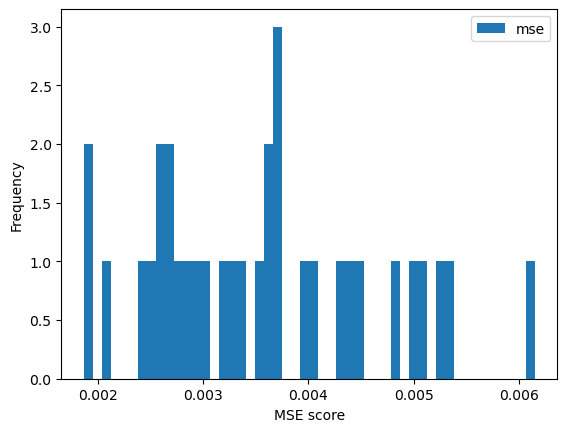

In [158]:
for test in exps:
    fig, ax = autoe[test].hist_scores(['mse'])

## Show model recreation capability of training and validation sets

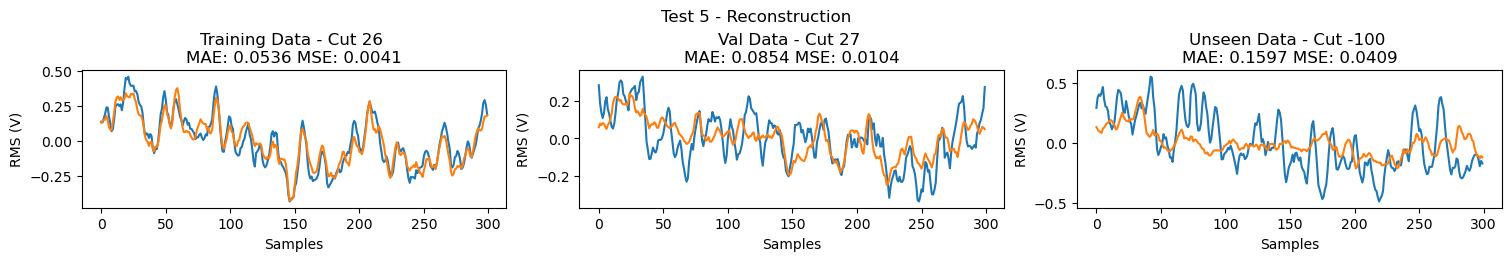

In [164]:
for test in exps:
    fig, ax = plt.subplots(1, 3, figsize=(15, 3), constrained_layout=True)
    fig.suptitle(f'{autoe[test].RMS.exp_name} - Reconstruction')
    ax = ax.ravel()

    # Training plot
    ax[0] = autoe[test].pred_plot(autoe[test]._ind_tr[0], plt_ax=ax[0])
    ax[0].set_title(f'Training Data - Cut {autoe[test]._ind_tr[0]} \n{ax[0].get_title()}')

    # Validation plot
    ax[1] = autoe[test].pred_plot(autoe[test]._ind_val[0], plt_ax=ax[1])
    ax[1].set_title(f'Val Data - Cut {autoe[test]._ind_val[0]} \n{ax[1].get_title()}')

    # Unseen plot
    i = -100
    ax[2] = autoe[test].pred_plot(i, input=(autoe[test].data, autoe[test].pred), plt_ax=ax[2])
    ax[2].set_title(f'Unseen Data - Cut {i} \n{ax[2].get_title()}')

    for a in ax:
        a.get_legend().remove()
        a.set_xlabel('Samples')
        a.set_ylabel('RMS (V)')

## Thresholds for anomaly detection of each model

In [137]:
for test in exps:
    autoe[test]._thres = None

In [138]:
for test in exps:
    autoe[test].thres


Cutoffs:
	MAE cutoff: 0.08606
	MSE cutoff: 0.01180
	R2 cutoff: 0.21609


## Show scores against threshold

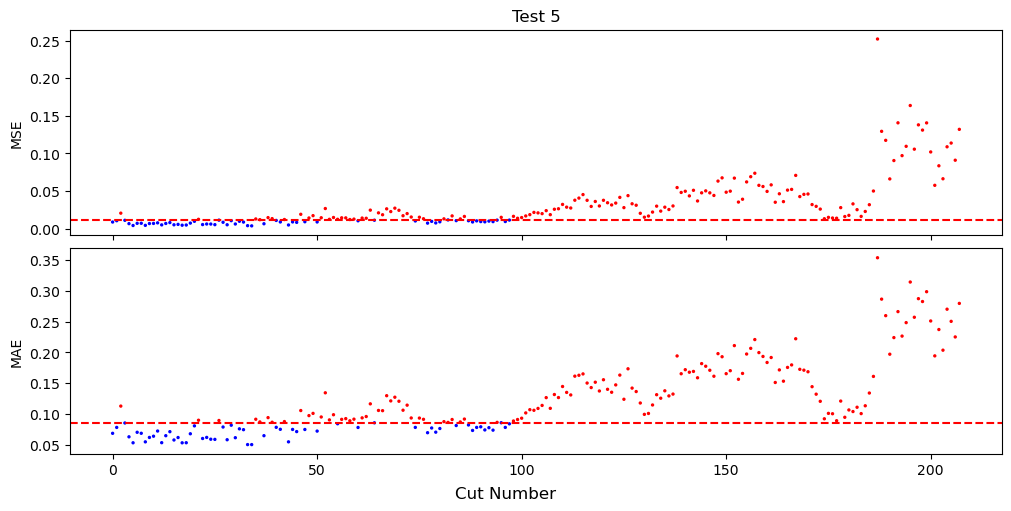

In [139]:
# metrics = ['mse', 'mae', 'r2']
metrics = ['mse', 'mae']

fig, ax = plt.subplots(len(metrics), len(exps),
                       figsize=(10, 5),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )
axes = fig.axes

for i, test in enumerate(exps):
    for j, met in enumerate(metrics):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        axes[(i)].set_title(test)
        axes[(len(exps) * j) + i].set_ylabel('')
        axes[(len(exps) * j) + i].set_xlabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')

_ = fig.supxlabel('Cut Number')

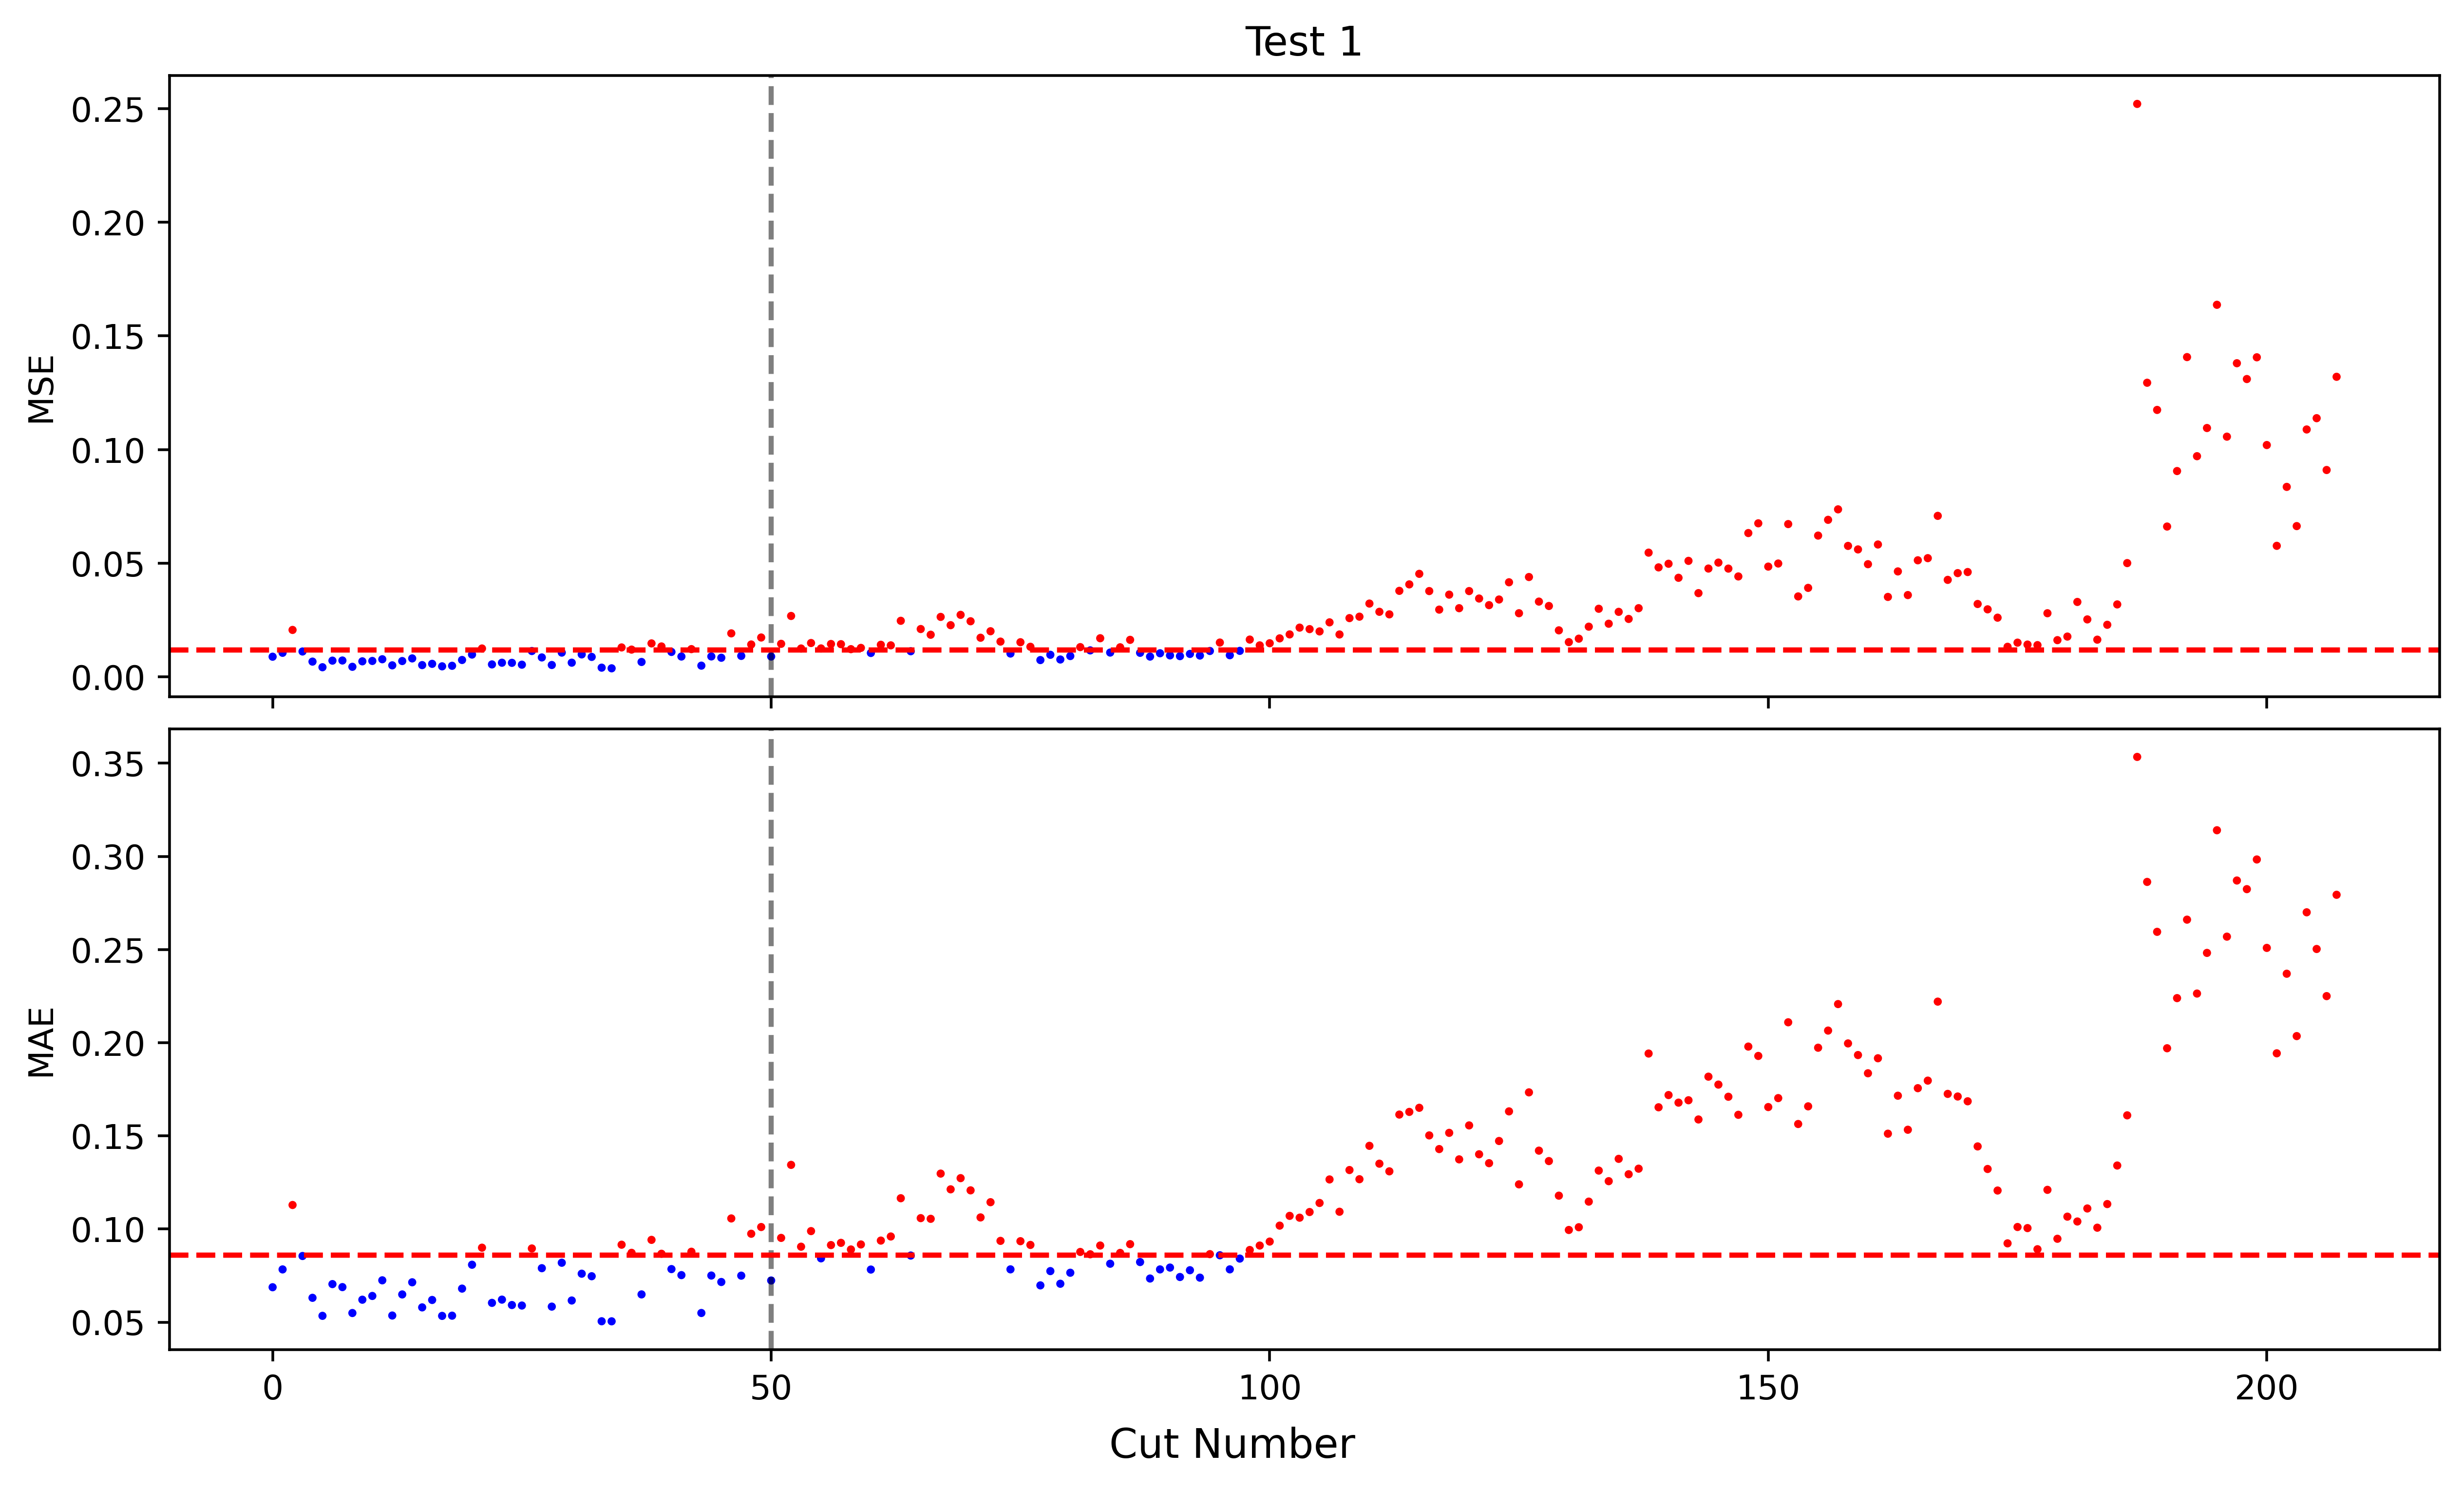

In [140]:
metrics = ['mse', 'mae']

fig, ax = plt.subplots(len(metrics), len(exps),
                       figsize=(10, 6),
                       constrained_layout=True,
                       sharex='col',
                       dpi=500
                       )
axes = fig.axes

for i, test in enumerate(exps):
    for j, met in enumerate(metrics):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])
        # score = autoe[test].scores[met]
        # axes[(i + (j * len(exps)))].scatter(x=range(len(score)),
        #                                     y=score,
        #                                     s=2,
        #                                     label=met,
        #                                     c='b'
        #                                     )

        axes[(len(exps) * j) + i].axvline(autoe[test]._train_slice.stop, #  * 300, # ONLY FOR LSTMAE WITH JOIN_DF
                                    color='k',
                                    linestyle='--',
                                    alpha=0.5,
                                    )

        axes[(i + (j * len(exps)))].axhline(autoe[test].thres[met], color='r', linestyle='--')

        axes[(i)].set_title(f'Test {i+ 1}')
        axes[(len(exps) * j) + i].set_ylabel('')
        axes[(len(exps) * j) + i].set_xlabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')

_ = fig.supxlabel('Cut Number')

In [141]:
dfs = [pd.DataFrame(autoe[test].scores) for test in exps]
df = pd.concat(dfs, keys=exps, names=['Test', 'Metrics'])
for test in exps:
    print(f'\n {test}')
    print(df.loc[test].describe())


 Test 5
              mae         mse          r2
count  208.000000  208.000000  208.000000
mean     0.126824    0.032478    0.192432
std      0.060362    0.034686    0.219841
min      0.050461    0.003780   -1.045780
25%      0.081767    0.010709    0.056321
50%      0.106427    0.019584    0.202496
75%      0.162918    0.041894    0.298042
max      0.353368    0.252048    0.809522


## autoe models latent space

In [142]:
# for test in exps:
#     fig, ax = autoe[test].plot_latent_space()

## Wear measurements comparison

/tmp/ipykernel_18287/1076541176.py:79: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


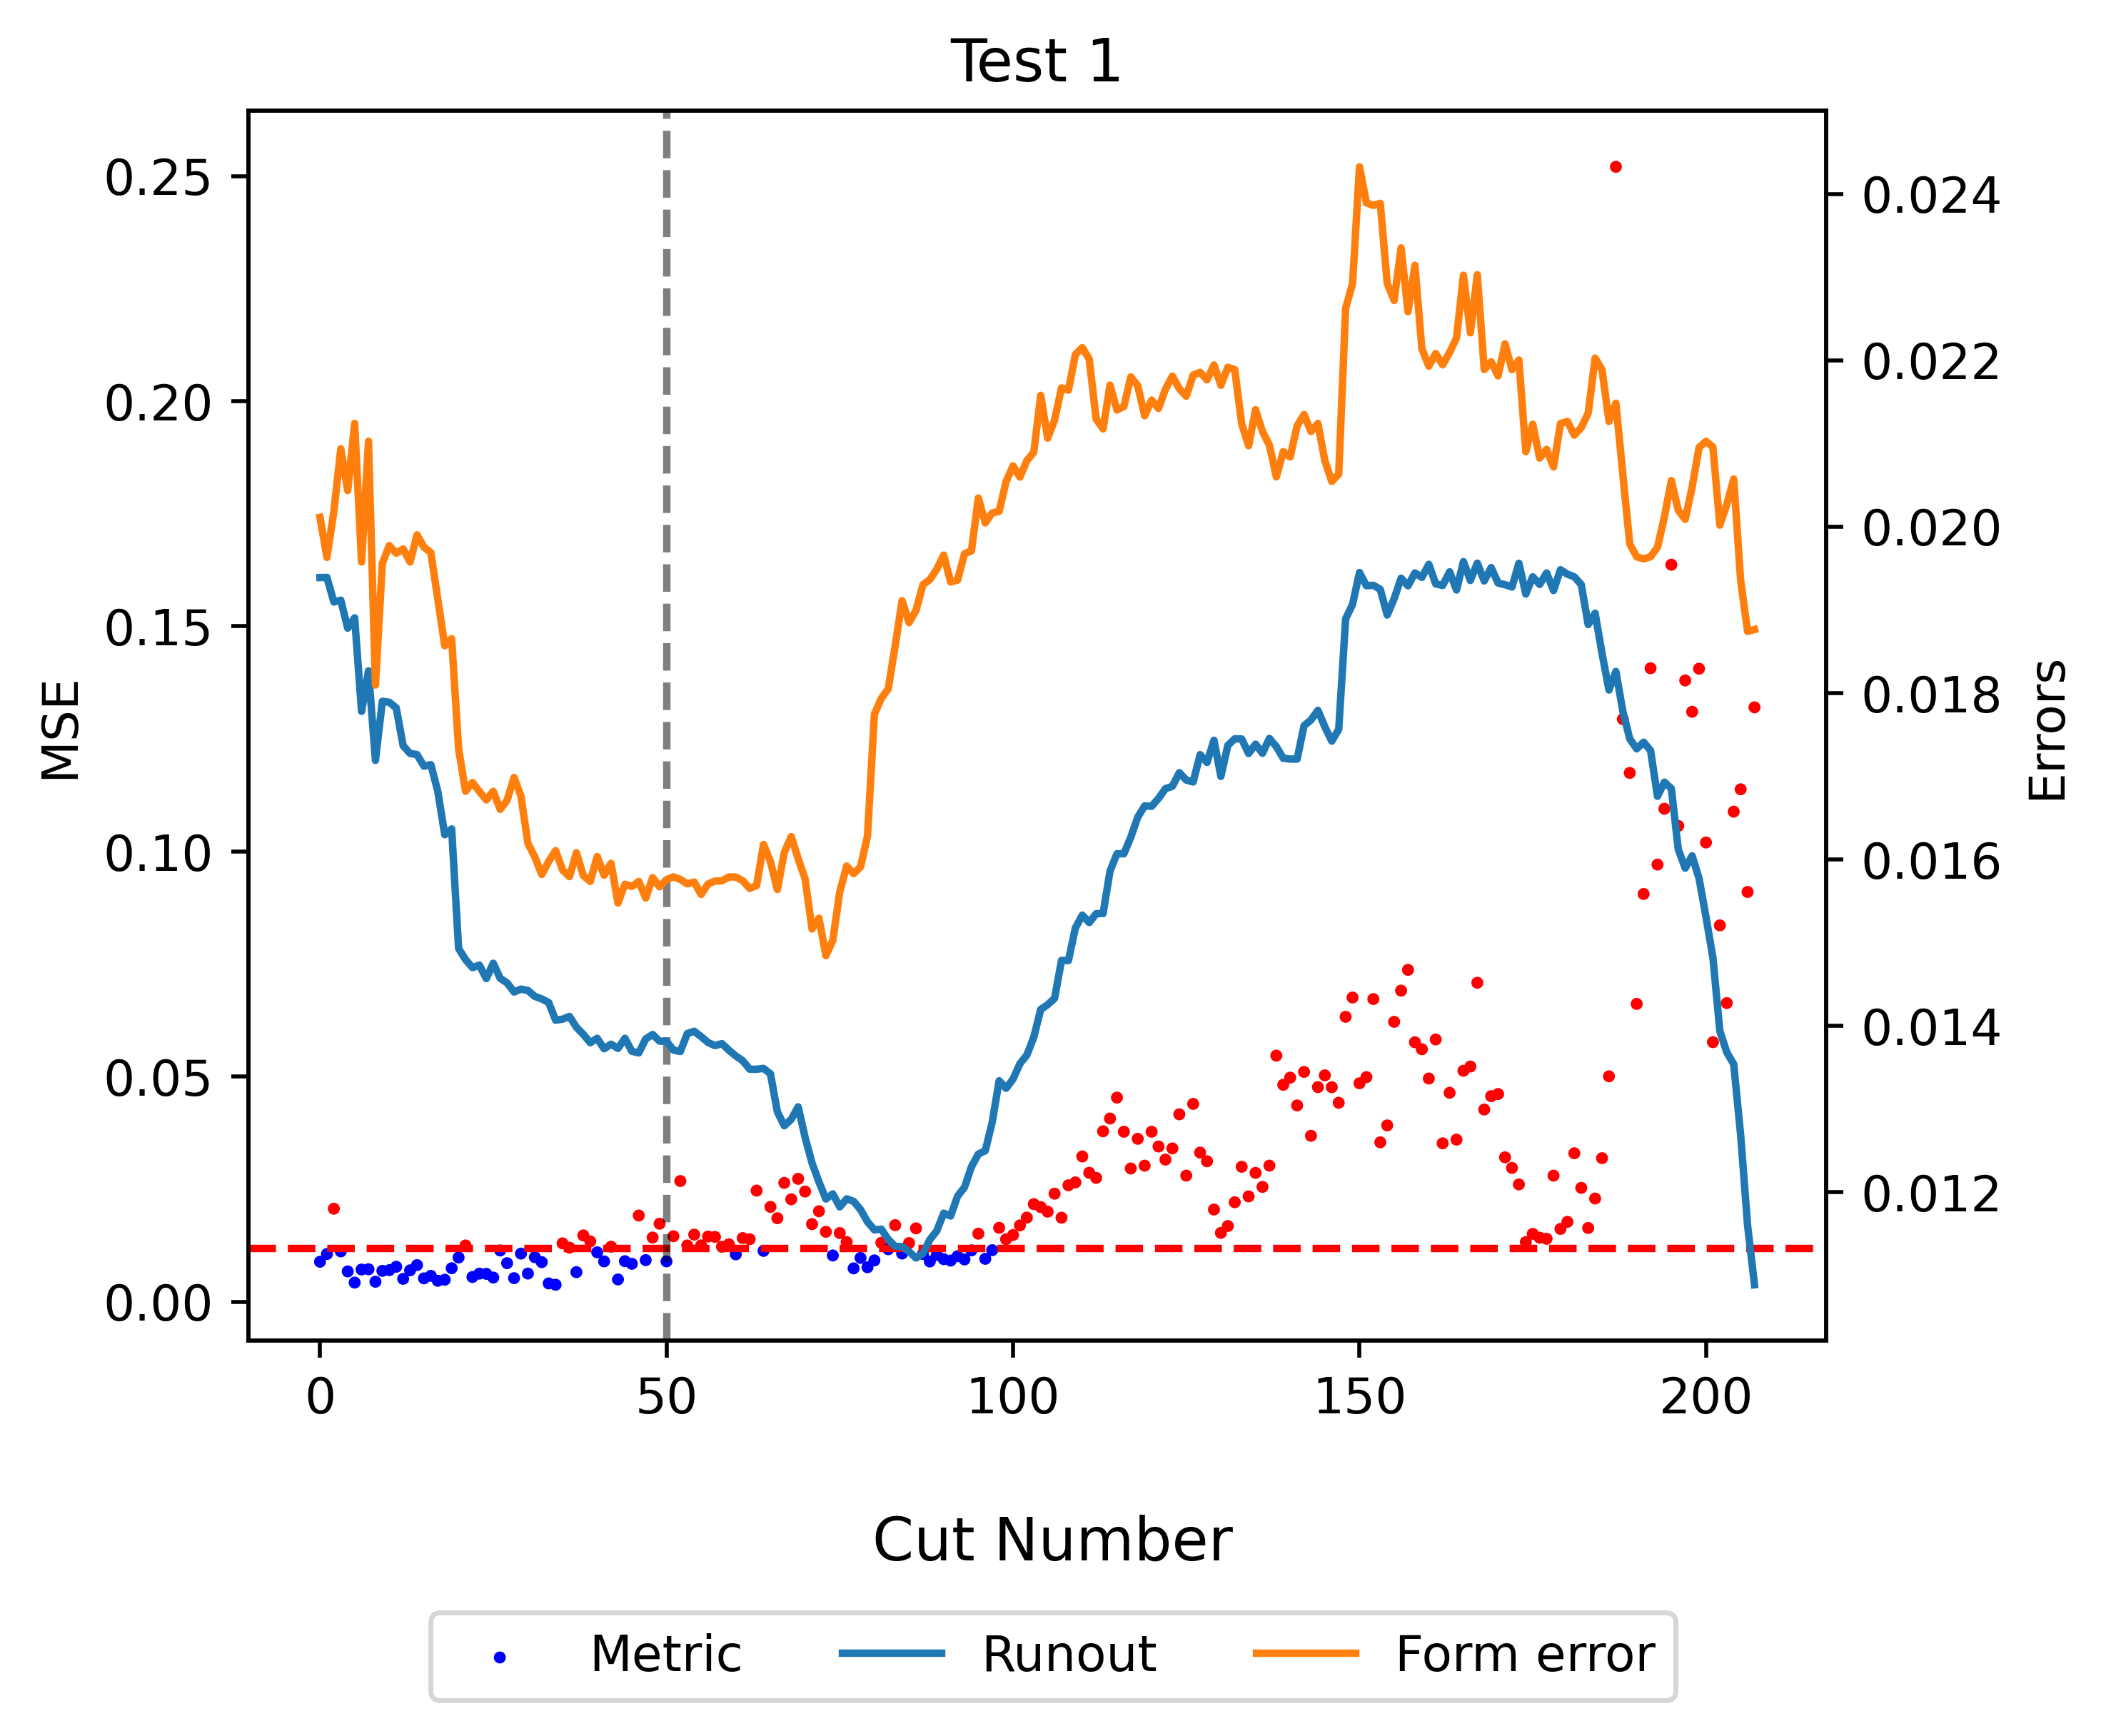

In [144]:
metric = ['mse', 'mae']
features = ['Runout', 'Form error']

fig, ax = plt.subplots(len(metric), len(exps),
                       figsize=(10, 6),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       dpi=500,
                       )

ax2 = []

try:
    ax.ravel()
    for a in ax.ravel():
        ax2.append(a.twinx())
except AttributeError:
    ax2.append(ax.twinx())

for a, b in zip(ax2[1:], ax2[0:-1]):
    a.sharey(b)

if len(metric) * len(exps) > 1:
    ax2 = np.reshape(ax2, ax.shape)

axes = fig.axes
axes2 = axes[-(len(axes) // 2):]
axes = axes[0:(len(axes) // 2)]
for i, test in enumerate(exps):
    axes[i].set_title(f'Test {i + 1}')
    # axes[i].set_title(test)

    exp = resources.load(test)
    for j, met in enumerate(metric):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        # vert line to show where training data ends
        axes[(len(exps) * j) + i].axvline(autoe[test]._train_slice.stop, # * 300, # ONLY FOR LSTM WITH JOIN_DF
                                    color='k',
                                    linestyle='--',
                                    alpha=0.5,
                                    )

        for feature in features:
            feat = exp.features[feature].drop([0, 1, 2])
            if test == 'Test 5':
                feat = feat.drop([23, 24])
            # axes2[(len(exps) * j) + i].plot(range(len(feat)), feat, label=feature)
            axes2[(len(exps) * j) + i].plot(range(0, len(autoe[test].scores[met])), #, 300), # ONLY FOR LSTM WITH JOIN_DF
                                            feat,
                                            label=feature
                                            )

        axes[(len(exps) * j) + i].set_xlabel('')
        axes[(len(exps) * j) + i].set_ylabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')
        if i ==len(exps) - 1:
            axes2[(len(exps) * j) + i].set_ylabel('Errors')

_ = fig.supxlabel('Cut Number')

for i, a in enumerate(axes2):
    if (i + 1) % len(exps) != 0:
        plt.setp(a.get_yticklabels(), visible=False)

l1, lab1 = axes[0].get_legend_handles_labels()
l2, lab2 = axes2[0].get_legend_handles_labels()

plt.figlegend(l1 + l2,
              ['Metric'] + lab2, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 0),
              ncol=len(l1 + l2)
              )
plt.tight_layout()

In [ ]:
for test in exps:
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    try:
        autoe[test].anom_plot(anomaly_metric='mse', plt_ax=ax)
    except AttributeError:
        pass

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(1, len(exps), figsize=(10,5), constrained_layout=True)
try:
    ax = ax.ravel()
except AttributeError:
    ax = [ax]

for i, test in enumerate(exps):
    a = autoe[test]
    sc = a.scores['mse'][a._ind_tr]

    def mad_based_outlier(points, thresh=2):
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

    outliers = sc[mad_based_outlier(sc)]
    print(np.min(outliers))

    sns.histplot(sc, ax=ax[i], kde=True, log_scale=False, bins=50)
    ax[i].plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

# Try Transfer Learning

In [ ]:
# First try the the model on the one used dataset and see how it performs
df_t9 = rms['Test 9'].data
jr_t9= []
for i in range(np.shape(df_t9)[1]):
    jr_t9.extend(df_t9.iloc[:, i].values.T)
jr_t9 = np.array(jr_t9).reshape(-1, 1)
print(f'Number of RMS samples: {np.shape(jr_t9)}')

assert ~np.isnan(jr_t9).any(), 'NaN values in RMS data'

# scale
jr_t9 = autoe['join_rms'].scaler.transform(jr_t9)

# sequence data
seq_t9 = autoe['join_rms'].sequence_inputs(jr_t9, autoe['join_rms'].seq_len)
print(f'Sequence data shape: {np.shape(seq_t9)}')

# predict
pred_t9 = autoe['join_rms'].model.predict(seq_t9)


In [ ]:
# score
i = 40000
autoe['join_rms'].pred_plot(i, input=(seq_t9, pred_t9))

In [ ]:
(x, pred), scores = autoe['join_rms'].score(x=(seq_t9), tb=False)

In [ ]:
metric = ['mse', 'mae', 'r2']
features = ['Runout', 'Form error']

fig, ax = plt.subplots(len(metric), len(exps),
                       figsize=(10, 6),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       dpi=500,
                       )

ax2 = []

try:
    ax.ravel()
    for a in ax.ravel():
        ax2.append(a.twinx())
except AttributeError:
    ax2.append(ax.twinx())

for a, b in zip(ax2[1:], ax2[0:-1]):
    a.sharey(b)

if len(metric) * len(exps) > 1:
    ax2 = np.reshape(ax2, ax.shape)

axes = fig.axes
axes2 = axes[-(len(axes) // 2):]
axes = axes[0:(len(axes) // 2)]
for i, test in enumerate(['Test 9']):
    axes[i].set_title(test)

    exp = resources.load(test)
    for j, met in enumerate(metric):
        score = scores[met]
        axes[(i + (j * len(exps)))].scatter(x=range(len(score)),
                                            y=score,
                                            s=2,
                                            label=met,
                                            c='b'
                                            )

        axes[(i + (j * len(exps)))].axhline(autoe['join_rms'].thres[met], color='r', linestyle='--')

        # vert line to show where training data ends
        # axes[(len(exps) * j) + i].axvline(autoe[test]._train_slice.stop * 300,
        #                             color='k',
        #                             linestyle='--',
        #                             alpha=0.5,
        #                             )

        for feature in features:
            feat = exp.features[feature].drop([0, 1, 2])
            if test == 'Test 5':
                feat = feat.drop([23, 24])
            # axes2[(len(exps) * j) + i].plot(range(len(feat)), feat, label=feature)
            axes2[(len(exps) * j) + i].plot(range(0, len(scores[met]), 300), feat, label=feature)

        axes[(len(exps) * j) + i].set_xlabel('')
        axes[(len(exps) * j) + i].set_ylabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')
        if i ==len(exps) - 1:
            axes2[(len(exps) * j) + i].set_ylabel('Errors')

_ = fig.supxlabel('Cut Number')

for i, a in enumerate(axes2):
    if (i + 1) % len(exps) != 0:
        plt.setp(a.get_yticklabels(), visible=False)

l1, lab1 = axes[0].get_legend_handles_labels()
l2, lab2 = axes2[0].get_legend_handles_labels()

plt.figlegend(l1 + l2,
              ['Metric'] + lab2, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 0),
              ncol=len(l1 + l2)
              )
plt.tight_layout()

In [ ]:
# Then try transfer learning with the other dataset to see if the model requires less training to perform well
autoe_2 = LSTMAutoEncoder(rms['Test 9'],
                          rms['Test 9'].data,
                          tb=True,
                          tb_logdir='LSTMAE_test',
                          train_slice=(0, 50),
                          val_frac=0.33,
                          params={'epochs': 300,
                                  'batch_size': 64,
                                  'n_size': [256, 128, 64],
                                  'seq_len': 100,
                                  'n_bottleneck': 32,
                                  'loss': 'mean_squared_error',
                                  'callbacks': [
                                          tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=10,
                                            mode='min',
                                            start_from_epoch= 150,
                                            ),
                                     ]
                          }
                    )

In [ ]:
name = autoe_2.run_name
model_folder = TB_DIR.joinpath(autoe_2._tb_logdir.joinpath(name))
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
assert os.path.exists(model_folder)

autoe_2.model.callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
    filepath=model_folder.joinpath(f'{name}.h5'),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    )
)

autoe_2.model.initialize(X=autoe_2.train_data[0], y=autoe_2.train_data[0])

In [ ]:
name = autoe['join_rms'].run_name
model_folder = TB_DIR.joinpath(autoe['join_rms']._tb_logdir.joinpath(name))
autoe_2.model.model_.load_weights(
    TB_DIR.joinpath(model_folder.joinpath(f'{name}.h5'),),
)

In [ ]:
# Make the Encoder static so training only occurs on the Decoder.
autoe_2.model.model_.get_layer('Encoder').trainable = False
autoe_2.model.model_.get_layer('Encoder').trainable

In [ ]:
autoe_2.fit(x=autoe_2.train_data,
            val_data=autoe_2.val_data,
            verbose=0,
            use_multiprocessing=True,
            )

In [ ]:
name = autoe_2.run_name
model_folder = TB_DIR.joinpath(autoe_2._tb_logdir.joinpath(name))
autoe_2.model.model_.load_weights(
    TB_DIR.joinpath(model_folder.joinpath(f'{name}.h5'),),
)
autoe_2.pred = None
autoe_2.scores = None

In [ ]:
pred_tr, scores_tr = autoe_2.score('train')
pred_val, scores_val = autoe_2.score('val')
pred_data, scores_data = autoe_2.score('dataset')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,3), constrained_layout=True)
fig.suptitle(f'{autoe_2.RMS.exp_name} - Reconstruction')
ax = ax.ravel()

# Training plot
ax[0] = autoe_2.pred_plot(autoe_2._ind_tr[0], plt_ax=ax[0])
ax[0].set_title(f'Training Data - Cut {autoe_2._ind_tr[0]} \n{ax[0].get_title()}')

# Validation plot
ax[1] = autoe_2.pred_plot(autoe_2._ind_val[0], plt_ax=ax[1])
ax[1].set_title(f'Val Data - Cut {autoe_2._ind_val[0]} \n{ax[1].get_title()}')

# Unseen plot
i = -100
ax[2] = autoe_2.pred_plot(i, input=(autoe_2.data, autoe_2.pred), plt_ax=ax[2])
ax[2].set_title(f'Unseen Data - Cut {i} \n{ax[2].get_title()}')

In [ ]:
metric = ['mse', 'mae']
features = ['Runout', 'Form error']

fig, ax = plt.subplots(len(metric), len(exps),
                       figsize=(10, 6),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       dpi=500,
                       )

ax2 = []

try:
    ax.ravel()
    for a in ax.ravel():
        ax2.append(a.twinx())
except AttributeError:
    ax2.append(ax.twinx())

for a, b in zip(ax2[1:], ax2[0:-1]):
    a.sharey(b)

if len(metric) * len(exps) > 1:
    ax2 = np.reshape(ax2, ax.shape)

axes = fig.axes
axes2 = axes[-(len(axes) // 2):]
axes = axes[0:(len(axes) // 2)]
for i, test in enumerate(['Test 9']):
    axes[i].set_title(f'Test {i + 1}')
    # axes[i].set_title(test)

    exp = resources.load(test)
    for j, met in enumerate(metric):
        _ = autoe_2.scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        # vert line to show where training data ends
        axes[(len(exps) * j) + i].axvline(autoe_2._train_slice.stop * 300,
                                    color='k',
                                    linestyle='--',
                                    alpha=0.5,
                                    )

        for feature in features:
            feat = exp.features[feature].drop([0, 1, 2])
            if test == 'Test 5':
                feat = feat.drop([23, 24])
            # axes2[(len(exps) * j) + i].plot(range(len(feat)), feat, label=feature)
            axes2[(len(exps) * j) + i].plot(range(0, len(autoe_2.scores[met]), 300), feat, label=feature)

        axes[(len(exps) * j) + i].set_xlabel('')
        axes[(len(exps) * j) + i].set_ylabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')
        if i ==len(exps) - 1:
            axes2[(len(exps) * j) + i].set_ylabel('Errors')

_ = fig.supxlabel('Cut Number')

for i, a in enumerate(axes2):
    if (i + 1) % len(exps) != 0:
        plt.setp(a.get_yticklabels(), visible=False)

l1, lab1 = axes[0].get_legend_handles_labels()
l2, lab2 = axes2[0].get_legend_handles_labels()

plt.figlegend(l1 + l2,
              ['Metric'] + lab2, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 0),
              ncol=len(l1 + l2)
              )
plt.tight_layout()

In [ ]:
# autoe_3 is with only the final layer of the decoder being trained rather than autoe_2 where the entire decoder is trained.
autoe_3 = LSTMAutoEncoder(rms['Test 9'],
                          rms['Test 9'].data,
                          tb=True,
                          tb_logdir='LSTMAE_test',
                          train_slice=(0, 50),
                          val_frac=0.33,
                          params={'epochs': 300,
                                  'batch_size': 64,
                                  'n_size': [256, 128, 64],
                                  'seq_len': 100,
                                  'n_bottleneck': 32,
                                  'loss': 'mean_squared_error',
                                  'callbacks': [
                                          tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=10,
                                            mode='min',
                                            start_from_epoch= 150,
                                            ),
                                     ]
                          }
                    )

In [ ]:
name = autoe_3.run_name
model_folder = TB_DIR.joinpath(autoe_3._tb_logdir.joinpath(name))
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
assert os.path.exists(model_folder)

autoe_3.model.callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
    filepath=model_folder.joinpath(f'{name}.h5'),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    )
)

autoe_3.model.initialize(X=autoe_3.train_data[0], y=autoe_3.train_data[0])

In [ ]:
name = autoe['join_rms'].run_name
model_folder = TB_DIR.joinpath(autoe['join_rms']._tb_logdir.joinpath(name))
autoe_3.model.model_.load_weights(
    TB_DIR.joinpath(model_folder.joinpath(f'{name}.h5'),),
)

In [ ]:
# Make the Encoder static so training only occurs on the Decoder.
autoe_3.model.model_.get_layer('Encoder').trainable = False
autoe_3.model.model_.get_layer('Encoder').trainable

In [ ]:
# Change so that only last layer of decoder is trainable
decoder = autoe_3.model.model_.get_layer('Decoder')
for i, layer in enumerate(decoder.layers):
    if i < 8:
        layer.trainable = False

In [ ]:
autoe_3.fit(x=autoe_3.train_data,
            val_data=autoe_3.val_data,
            verbose=0,
            use_multiprocessing=True,
            )

In [ ]:
name = autoe_3.run_name
model_folder = TB_DIR.joinpath(autoe_3._tb_logdir.joinpath(name))
autoe_3.model.model_.load_weights(
    TB_DIR.joinpath(model_folder.joinpath(f'{name}.h5'),),
)
autoe_3.pred = None
autoe_3.scores = None

In [ ]:
pred_tr, scores_tr = autoe_3.score('train')
pred_val, scores_val = autoe_3.score('val')
pred_data, scores_data = autoe_3.score('dataset')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,3), constrained_layout=True)
fig.suptitle(f'{autoe_3.RMS.exp_name} - Reconstruction')
ax = ax.ravel()

# Training plot
ax[0] = autoe_3.pred_plot(autoe_3._ind_tr[0], plt_ax=ax[0])
ax[0].set_title(f'Training Data - Cut {autoe_3._ind_tr[0]} \n{ax[0].get_title()}')

# Validation plot
ax[1] = autoe_3.pred_plot(autoe_3._ind_val[0], plt_ax=ax[1])
ax[1].set_title(f'Val Data - Cut {autoe_3._ind_val[0]} \n{ax[1].get_title()}')

# Unseen plot
i = -100
ax[2] = autoe_3.pred_plot(i, input=(autoe_3.data, autoe_3.pred), plt_ax=ax[2])
ax[2].set_title(f'Unseen Data - Cut {i} \n{ax[2].get_title()}')

In [ ]:
metric = ['mse', 'mae']
features = ['Runout', 'Form error']

fig, ax = plt.subplots(len(metric), len(exps),
                       figsize=(10, 6),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       dpi=500,
                       )

ax2 = []

try:
    ax.ravel()
    for a in ax.ravel():
        ax2.append(a.twinx())
except AttributeError:
    ax2.append(ax.twinx())

for a, b in zip(ax2[1:], ax2[0:-1]):
    a.sharey(b)

if len(metric) * len(exps) > 1:
    ax2 = np.reshape(ax2, ax.shape)

axes = fig.axes
axes2 = axes[-(len(axes) // 2):]
axes = axes[0:(len(axes) // 2)]
for i, test in enumerate(['Test 9']):
    axes[i].set_title(f'Test {i + 1}')
    # axes[i].set_title(test)

    exp = resources.load(test)
    for j, met in enumerate(metric):
        _ = autoe_3.scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        # vert line to show where training data ends
        axes[(len(exps) * j) + i].axvline(autoe_3._train_slice.stop * 300,
                                    color='k',
                                    linestyle='--',
                                    alpha=0.5,
                                    )

        for feature in features:
            feat = exp.features[feature].drop([0, 1, 2])
            if test == 'Test 5':
                feat = feat.drop([23, 24])
            # axes2[(len(exps) * j) + i].plot(range(len(feat)), feat, label=feature)
            axes2[(len(exps) * j) + i].plot(range(0, len(autoe_3.scores[met]), 300), feat, label=feature)

        axes[(len(exps) * j) + i].set_xlabel('')
        axes[(len(exps) * j) + i].set_ylabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')
        if i ==len(exps) - 1:
            axes2[(len(exps) * j) + i].set_ylabel('Errors')

_ = fig.supxlabel('Cut Number')

for i, a in enumerate(axes2):
    if (i + 1) % len(exps) != 0:
        plt.setp(a.get_yticklabels(), visible=False)

l1, lab1 = axes[0].get_legend_handles_labels()
l2, lab2 = axes2[0].get_legend_handles_labels()

plt.figlegend(l1 + l2,
              ['Metric'] + lab2, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 0),
              ncol=len(l1 + l2)
              )
plt.tight_layout()